# 第25讲 机器学习：泰坦尼克存活率预测

In [1]:
import re
import pandas as pd

## 1. 数据准备

In [2]:
df_train = pd.read_csv('./datas/titanic/titanic_train.csv')
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_test = pd.read_csv('./datas/titanic/titanic_test.csv')
df_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 2. 数据清洗

### 2.1 填充缺失值

In [4]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df_train.loc[:, 'Age'] = df_train['Age'].fillna(df_train['Age'].mode()[0])
df_train.loc[:, 'Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode()[0])

In [6]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
df_test.loc[:, 'Age'] = df_test['Age'].fillna(df_test['Age'].mode()[0])
df_test.loc[:, 'Fare'] = df_test['Fare'].fillna(df_test['Fare'].median())

### 2.2 离散数据连续化

In [8]:
df_train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [9]:
df_train.loc[df_train['Sex']=='male', 'Sex'] = 0
df_train.loc[df_train['Sex']=='female', 'Sex'] = 1
df_test.loc[df_test['Sex']=='male', 'Sex'] = 0
df_test.loc[df_test['Sex']=='female', 'Sex'] = 1

In [10]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [11]:
df_train.loc[df_train['Embarked']== 'S', 'Embarked'] = 0
df_train.loc[df_train['Embarked']== 'C', 'Embarked'] = 1
df_train.loc[df_train['Embarked']== 'Q', 'Embarked'] = 2
df_test.loc[df_test['Embarked']== 'S', 'Embarked'] = 0
df_test.loc[df_test['Embarked']== 'C', 'Embarked'] = 1
df_test.loc[df_test['Embarked']== 'Q', 'Embarked'] = 2

## 3. 特征工程

### 3.1 家庭规模

In [12]:
df_train.loc[:, 'FamilySize'] = df_train['SibSp'] + df_train['Parch']
df_test.loc[:, 'FamilySize'] = df_test['SibSp'] + df_test['Parch']

### 3.2 姓名长度

In [13]:
df_train.loc[:, 'NameLength'] = df_train['Name'].apply(lambda x: len(x))
df_test.loc[:, 'NameLength'] = df_test['Name'].apply(lambda x: len(x))

### 3.3 身份头衔

In [14]:
def get_title(dataframe):
    name = dataframe['Name']
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''

df_train.loc[:, 'Title'] = df_train.apply(get_title, axis=1)
df_test.loc[:, 'Title'] = df_test.apply(get_title, axis=1)

In [15]:
title_map = {'Mr': 1, 'Miss': 2, 'Ms': 2, 'Mrs': 3, 'Master': 4, 'Dr': 5, 'Rev': 6,
             'Major': 7, 'Col': 7, 'Capt': 7, 'Mlle': 8, 'Mme': 8, 'Don': 9, 'Sir': 9,
             'Lady': 10, 'Countess': 10, 'Jonkheer': 10, 'Dona': 11}
df_train.loc[:, 'Title'] = df_train['Title'].map(title_map)
df_test.loc[:, 'Title'] = df_test['Title'].map(title_map)

### 3.4 特征选择

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

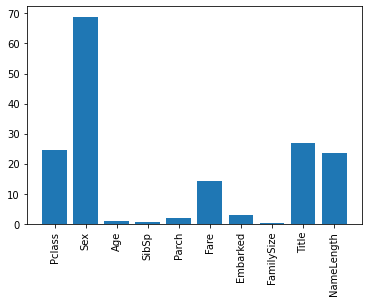

In [17]:
predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title', 'NameLength']
selector = SelectKBest(f_classif, k=5)
selector.fit(df_train[predictors], df_train["Survived"])
scores = -np.log10(selector.pvalues_)
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [18]:
# predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
predictors = ['Pclass', 'Sex', 'Fare', 'Title', 'NameLength']
X = df_train.loc[:, predictors]
Y = df_train.loc[:, 'Survived']

## 3. 线性回归（0.77）

### 3.1 模型训练

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
linreg = LinearRegression()
linreg.fit(X, Y)

LinearRegression()

In [21]:
linreg.score(X, Y)

0.377637173960207

### 3.2 预测验证

In [22]:
pred = linreg.predict(df_test[predictors])

In [23]:
pred[pred > .5] = 1
pred[pred <=.5] = 0
pred = pred.astype('int64')

In [24]:
df = pd.DataFrame({'PassengerId': df_test.loc[:, 'PassengerId'], 'Survived': pred})
df.to_csv('./datas/titanic/LinearRegression.csv', index=False)

## 4. 逻辑回归（0.75）

### 4.1 模型训练

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
logreg = LogisticRegression()
logreg.fit(X, Y)

LogisticRegression()

In [27]:
logreg.score(X, Y)

0.7901234567901234

### 4.2 预测验证

In [28]:
pred = logreg.predict(df_test[predictors])

In [29]:
df = pd.DataFrame({'PassengerId': df_test.loc[:, 'PassengerId'], 'Survived': pred})
df.to_csv('./datas/titanic/LogisticRegression.csv', index=False)

## 5. 随机森林（0.75）

### 5.1 模型训练

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rdmforest = RandomForestClassifier(
    random_state=1,
    n_estimators=50,
    min_samples_split=4,
    min_samples_leaf=2
)
rdmforest.fit(X, Y)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=4, n_estimators=50,
                       random_state=1)

In [32]:
rdmforest.score(X, Y)

0.9124579124579124

### 5.2 预测验证

In [33]:
pred = logreg.predict(df_test[predictors])

In [34]:
df = pd.DataFrame({'PassengerId': df_test.loc[:, 'PassengerId'], 'Survived': pred})
df.to_csv('./datas/titanic/RandomForestClassifier.csv', index=False)

## 6. 梯度提升（0.77）

### 6.1 模型训练

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

In [36]:
grdboosting = GradientBoostingClassifier(n_estimators=25, max_depth=3)
grdboosting.fit(X, Y)

GradientBoostingClassifier(n_estimators=25)

In [37]:
grdboosting.score(X, Y)

0.8473625140291807

### 6.2 预测验证

In [38]:
pred = grdboosting.predict(df_test[predictors])

In [39]:
df = pd.DataFrame({'PassengerId': df_test.loc[:, 'PassengerId'], 'Survived': pred})
df.to_csv('./datas/titanic/GradientBoostingClassifier.csv', index=False)